# CS 480/680 assignment 3

Tips:
- Please save a copy of this notebook to avoid losing your changes.
- Debug your code and ensure that it can run.
- Save the output of each cell. Failure to do so may result in your coding questions not being graded.
- To accelerate the training time, you can choose 'Runtime' -> 'Change runtime type' -> 'Hardware accelerator' and set 'Hardware accelerator' to 'GPU'.
- Your grade is independent of the accuracy of your models. Your grade will depend on the correctness of your code and implementation.

Tips for sumbission:
- Do not change the order of the problems.
- Select 'Runtime' -> 'Run all' to run all cells and generate a final "gradable" version of your notebook and save your ipynb file.
- Also use 'File' -> 'Print' and then print your report from your browser into a PDF file.

## Question 1 - Implementing GAN for MNIST dataset (35 points)

In this question we are going to impelement a generative network that can generate MNIST handwritten digits from random Gaussian noise.

### Q1.1 (2 points)

We start by creating the data loaders. Note that each MNIST image is of size 28\*28. The **first task** is to build the ```data_loader```

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os


# Setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 100
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

#ToDo: Build the train data loader using the above batch_size varibale and shuffling the dataset.
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


### Q1.2 Generator (5 points)
We will be building simple Generator and Discriminators that only consist of fully-connected layers. The Generator takes as input a Gaussian vector with dimension ```n_dim```. It consists of two linear layers with ```256``` and ```512``` nodes and the output layer should of dimension ```28*28=784``` so that it can be considered as unfolding a ```28*28``` image into a vector. The **second task** is to complete the following code for building the Generator.

In [30]:
class Generator(nn.Module):
    def __init__(self, n_dim):
        super(Generator, self).__init__()
        #ToDo: Complete the code
        #The activation function for the two hidden layers is ReLU.
        #The last layer's activation function is Tanh.
        self.fc1 = nn.Linear(n_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()


    def forward(self, x):
        #ToDo: Complete this function. The function takes as input x and outputs the result of applying the generator on x.
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x


### Q1.3 Discriminator (5 points)
The Discriminator takes as input an image of size ```28*28```. It consists of two linear layers with ```512``` and ```256``` nodes and the output layer should be a single node. The **third task** complete the following code for building the Discriminator.

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
            #ToDo: Complete the code
            #The activation functions for the two hidden layers are ReLU.
            #The last layer's activation function is Sigmoid.
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = x.view(x.size(0), -1) # Making sure that the batch of images has the shape [batch_size,28*28] instead of [batch_size,1,28,28]
        #ToDo: Complete this function. The function takes as input x and outputs the result of applying the generator on x.
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


### Q1.4 Initializaiton (2 points)

The **fourth task** is to define the optimizers.

In [32]:
n_dim = 100
generator = Generator(n_dim).to(device)
discriminator = Discriminator().to(device)
lr = 0.0002


criterion = nn.BCELoss()
#ToDo: define the two different Adam optimizers for generator and discriminator with learning rates of lr.

d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

### Q1.5 Training (16 points)

Note that when applying the ```criterion``` both the inputs should be on the same device. If you are defining a set of labels that you want to use in ```criterion``` you must move them to ```device``` first.

Recall from the Goodfellow et al. 2014 that the following happens during the minimax game between Discriminator and the Generator.

Discriminator is ascending
$\nabla\frac{1}{m}\sum_{i=1}^m\log D(x^{(i)}) + \log(1-D(G(z^{(i)})))$ where $D$ and $G$ denote the Districiminator and the Generator, respectively. Here, $x^{1},\ldots,x^{m}$ is the batch of training examples (i.e., MNIST images) and $z^{(1)},\ldots,z^{(m)}$ is a batch of random noise.

Also note that for two batches $x=\{x^{1},\ldots,x^{m}\}$ and $y=\{y^{1},\ldots,y^{m}\}$ the BCELoss function $l(x,y)$ computes the following.
$$l(x,y) = \frac{1}{m}\sum_{i=1}^m y^{(i)}\log x^{(i)} + (1-y^{(i)})\log (1- x^{(i)})$$

The **fifth task** is to make sure that ```d_loss``` is computing the quantity that discriminator wants to ascend. This is achieved by setting ```d_loss = d_loss_real + d_loss_fake``` and letting ```d_loss_real``` to be $\frac{1}{m}\sum_{i=1}^m\log D(x^{(i)})$ and ```d_loss_fake``` to be $\frac{1}{m}\sum_{i=1}^m \log(1-D(G(z^{(i)})))$. Hint: ```d_loss_real``` is already implemented.

We now turn to train the generator. Initially, the generator wants to descend the following $\nabla\frac{1}{m}\sum_{i=1}^m \log(1-D(G(z^{(i)})))$. However, this may affect the training of the generator specifically in the early stages of training where the discriminator can confidently reject the generated examples [Goodfellow et al., 2014]. Instead, we will require the generator to ascend $\nabla\frac{1}{m}\sum_{i=1}^m \log(D(G(z^{(i)})))$. The **sixth task** is to compute ```g_loss``` used for training the generator.


In [33]:
num_epochs = 50
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        real_images = images.to(device)

        # Training discriminator
        discriminator.zero_grad()
        real_outputs = discriminator(real_images)
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        d_loss_real = criterion(real_outputs, real_labels)

        #ToDo: Compute d_loss_fake
        z = torch.randn(batch_size, n_dim).to(device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images)
        fake_labels = torch.zeros(fake_images.size(0), 1).to(device)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        fake_score = fake_outputs


        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Training generator
        generator.zero_grad()

        #ToDo: compute g_loss
        z = torch.randn(batch_size, n_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        real_labels = torch.ones(fake_images.size(0), 1).to(device)
        g_loss = criterion(outputs, real_labels)

        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 300 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'Discriminator Loss: {d_loss.item():.4f}, '
                  f'Generator Loss: {g_loss.item():.4f}')

Epoch [1/50], Step [300/600], Discriminator Loss: 0.3335, Generator Loss: 3.6812
Epoch [1/50], Step [600/600], Discriminator Loss: 0.1027, Generator Loss: 4.8390
Epoch [2/50], Step [300/600], Discriminator Loss: 0.3501, Generator Loss: 3.7569
Epoch [2/50], Step [600/600], Discriminator Loss: 0.2524, Generator Loss: 3.0594
Epoch [3/50], Step [300/600], Discriminator Loss: 0.3659, Generator Loss: 3.6568
Epoch [3/50], Step [600/600], Discriminator Loss: 0.5375, Generator Loss: 5.5310
Epoch [4/50], Step [300/600], Discriminator Loss: 0.5706, Generator Loss: 1.5681
Epoch [4/50], Step [600/600], Discriminator Loss: 0.1767, Generator Loss: 3.6159
Epoch [5/50], Step [300/600], Discriminator Loss: 0.2325, Generator Loss: 3.6290
Epoch [5/50], Step [600/600], Discriminator Loss: 0.3731, Generator Loss: 3.3580
Epoch [6/50], Step [300/600], Discriminator Loss: 0.2926, Generator Loss: 4.1402
Epoch [6/50], Step [600/600], Discriminator Loss: 0.8758, Generator Loss: 3.6118
Epoch [7/50], Step [300/600]

### Q1.6 Plotting the results (5 points)
The **seventh and final task** for this question is to try the trained generator. Generate 4 random vectors, apply the generator on them, and plot the resulting image in a single 2 by 2 plot.

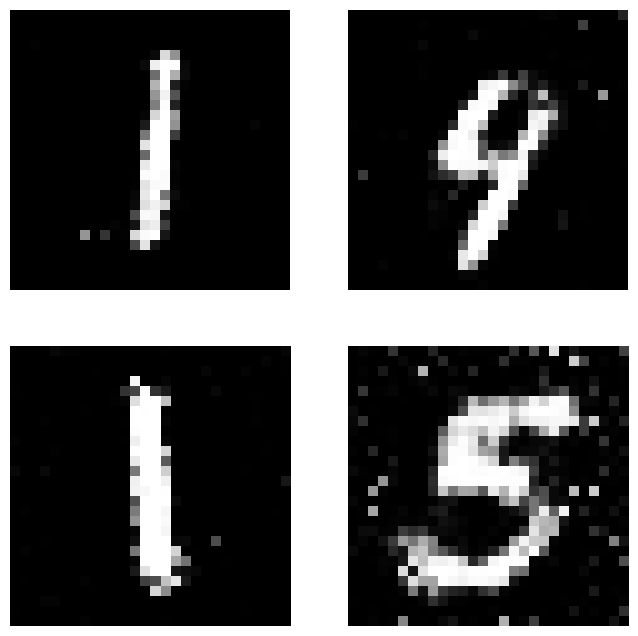

In [99]:
rand_vec = torch.randn(4, n_dim).to(device)
with torch.no_grad():
  fake_images = generator(rand_vec)
  fake_images = fake_images.view(-1, 28, 28).cpu().detach().numpy()

# Create a 2x2 grid plot for the generated images
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    for j in range(2):
        axes[i, j].imshow(fake_images[i * 2 + j], cmap='gray')
        axes[i, j].axis('off')

# Display the plot
plt.show()

## Question 2 - Transformers (65 points)
In this question we will be implementing a transformer architecture and apply it on a simple artificially generated dataset.

### Q2.1 Multi-Head Attention (9 points)

The attention layer works on batches of training data where each training data itself is a sequence of words/token with length at most ```seq_length``` and each word is embedded into a ```d_embedding``` dimensional vector, e.g., later when we run the transformer on the artificial dataset, the inputs to the transformer and attention layer have shapes of ```[batch_size,seq_length,d_embedding]```. Recall from the lecture that a multi-head attention layer consists of ```n_heads``` self-attention heads. The input matrices Query Q, Key K, and Value V to multi-attention head are passed through linear layers $W_Q$, $W_K$, and $W_V$ which are trainable parameters. The multi-head attention will divide the embedding vector of the input into ```n_heads``` vector of size ```d_k``` and use each as an attention head. This is particularly done by the ```make_heads``` function which transforms the input to an output of shape ```[batch_size, n_heads, seq_length, d_k]```. The multi-head attention then computes the probabilities using the input values, which is implemented by the ```compute_attention_probs``` function. It then joins them using the ```join_heads``` function and finally passes them through an output linear layer $W_O$. The **first task** is to implement the ```forward``` function of Multi-Head attention using the functions already implemented.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy


class MultiHeadAttention(nn.Module):
    def __init__(self, d_embedding, n_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_embedding % n_heads == 0

        self.d_embedding = d_embedding
        self.n_heads = n_heads
        self.d_k = d_embedding // n_heads

        self.W_q = nn.Linear(d_embedding, d_embedding)
        self.W_k = nn.Linear(d_embedding, d_embedding)
        self.W_v = nn.Linear(d_embedding, d_embedding)
        self.W_o = nn.Linear(d_embedding, d_embedding)

    def compute_attention_probs(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output


    def make_heads(self, x):
        batch_size, seq_length, d_embedding = x.size()
        y=x.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)
        return x.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)

    def join_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_embedding)


    def forward(self, Q, K, V, mask=None):
       #ToDo: Complete code
      Q_proj = self.W_q(Q)
      K_proj = self.W_k(K)
      V_proj = self.W_v(V)

      # Make heads
      Q_heads = self.make_heads(Q_proj)
      K_heads = self.make_heads(K_proj)
      V_heads = self.make_heads(V_proj)

      # Compute attention probabilities
      attention_output = self.compute_attention_probs(Q_heads, K_heads, V_heads, mask)
      joined_output = self.join_heads(attention_output)
      output = self.W_o(joined_output)

      return output



### Q2.2 Feed-forward layer (2 points)
The output of the multi-head attention layer is used as an input to the feed-forward layer in the encoder. This layer is implemented in the following class. The **second task** is to complete the ```forward``` function of this class.

In [36]:
class FeedForward(nn.Module):
    def __init__(self, d_embedding, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_embedding, d_ff)
        self.fc2 = nn.Linear(d_ff, d_embedding)
        self.relu = nn.ReLU()

    def forward(self, x):
        #ToDO: Complete code
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

### Q2.3 Encoder Block (9 points)

We now have all the necessary classes to build the Encoder block. The encoder block gets as input a batch of data. It first passes the input through the multi-attention layer. It then applies 1) a droput layer, 2) adds the input to the output of droupout layer as a residual, 3) applies a layer normalization, 4) and passes the output to the feed-forward layer. Finally, it applies 1) a droput layer, 2) adds the input to the output of droupout layer as a residual, and 3) Applies a layer normalization. The **third task** is to complete the ```forward``` function of this class.

In [37]:
class EncoderBlock(nn.Module):
    def __init__(self, d_embedding, n_heads, d_ff, dropout):
        super(EncoderBlock, self).__init__()
        self.self_attention = MultiHeadAttention(d_embedding, n_heads)
        self.feed_forward = FeedForward(d_embedding, d_ff)
        self.norm1 = nn.LayerNorm(d_embedding)
        self.norm2 = nn.LayerNorm(d_embedding)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        #ToDo: Complete code
        """
        Returns: The output of encoder on a given input batch x
        """
        atten = self.self_attention(x,x,x, mask)
        x = x + self.dropout(atten)
        x = self.norm1(x)
        x = self.feed_forward(x)

        #adding resid again
        x = x + self.dropout(x)
        x = self.norm2(x)
        return x


### Q2.4 Decoder Block (20 points)

In this part we will build the decoder block. The **fourth task** is to implement the DecoderBlock. You can refer to the lecture notes to find the architecture of the decoder block including the multi-attention layers, add and norm layers, and the feedforward layer. You can also add a *dropout* layer to the final add and norm layer.


In [38]:
class DecoderBlock(nn.Module):
    def __init__(self, d_embedding, n_heads, d_ff, dropout):
        super(DecoderBlock, self).__init__()
        """
        Args:
           self_attention: decoder's multi-head attention
           cross_attention: The multi-head attention layer between the encoder and the decoder
           feed_forward: feed-forward layer
           mask: mask to be given for multi head attention
           norm1: First Normalization layer
           norm2: Second Normalization layer
           norm3: Third Normalization layer
           dropout: Final dropout layer
        """
        self.self_attention = MultiHeadAttention(d_embedding, n_heads)
        self.cross_attention = MultiHeadAttention(d_embedding, n_heads)
        self.feed_forward = FeedForward(d_embedding, d_ff)
        self.norm1 = nn.LayerNorm(d_embedding)
        self.norm2 = nn.LayerNorm(d_embedding)
        self.norm3 = nn.LayerNorm(d_embedding)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x, enc_output, src_mask, tgt_mask):
        """
        Returns: The output of decoder on a given input batch x
        """

        #decoder attention
        attention_output = self.self_attention(x,x,x, tgt_mask)
        x = x + self.dropout(attention_output)
        x = self.norm1(x)

        #cross attention
        cross_output = self.cross_attention(x,enc_output,enc_output, src_mask)
        x = x + self.dropout(cross_output)
        x = self.norm2(x)


        #feed-forward
        feed_output = self.feed_forward(x)
        x = x + self.dropout(feed_output)
        x = self.norm2(x)

        return x

### Q2.5 Transformer Block (20 points)

Finally, we use the classes defined for EncoderBlock and DecoderBlock to build the TransformerBlock. The **fifth task** is to complete the ```forward``` function of this class. Note that ```num_layers``` indicates the number of encoder and decoder layers in the transformer. You can refer to the final architecture of the Transformer from the lectures. You can also include a dropout layer after embedding the source and target inputs. Remember to apply positional encoding to the input batch before passing it to the transformer.

In [39]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_embedding, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_embedding)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embedding, 2).float() * -(math.log(10000.0) / d_embedding))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_embedding, n_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_embedding)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_embedding)
        self.positional_encoding = PositionalEncoding(d_embedding, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderBlock(d_embedding, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderBlock(d_embedding, n_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_embedding, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    # Masking the input; the outputs returned by this function should be passed to encoder and decoder layers
    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        #ToDo: complete the code
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        """
        Returns: The output of transformer on a given input batch x
        """
        src_embedded = self.encoder_embedding(src)
        src_embedded = self.positional_encoding(src_embedded)

        encoder_output = src_embedded
        for encoder_layer in self.encoder_layers:
            encoder_output = encoder_layer(encoder_output, src_mask)

        tgt_embedded = self.decoder_embedding(tgt)
        tgt_embedded = self.positional_encoding(tgt_embedded)


        decoder_output = tgt_embedded
        for decoder_layer in self.decoder_layers:
            decoder_output = decoder_layer(decoder_output, encoder_output, src_mask, tgt_mask)

        output = self.fc(self.dropout(decoder_output))
        return output




### Q2.6 Training (5 points)
We can now train the model on an imaginary randomly generated dataset. The **sixth task** is to complete the training code and plot the training loss.

Epoch [1/25], Loss: 8.6991 
Epoch [2/25], Loss: 8.5934 
Epoch [3/25], Loss: 8.5271 
Epoch [4/25], Loss: 8.4771 
Epoch [5/25], Loss: 8.4330 
Epoch [6/25], Loss: 8.3841 
Epoch [7/25], Loss: 8.3298 
Epoch [8/25], Loss: 8.2679 
Epoch [9/25], Loss: 8.2058 
Epoch [10/25], Loss: 8.1320 
Epoch [11/25], Loss: 8.0658 
Epoch [12/25], Loss: 8.0053 
Epoch [13/25], Loss: 7.9380 
Epoch [14/25], Loss: 7.8679 
Epoch [15/25], Loss: 7.7991 
Epoch [16/25], Loss: 7.7157 
Epoch [17/25], Loss: 7.6458 
Epoch [18/25], Loss: 7.5762 
Epoch [19/25], Loss: 7.4988 
Epoch [20/25], Loss: 7.4174 
Epoch [21/25], Loss: 7.3456 
Epoch [22/25], Loss: 7.2677 
Epoch [23/25], Loss: 7.1898 
Epoch [24/25], Loss: 7.1191 
Epoch [25/25], Loss: 7.0398 


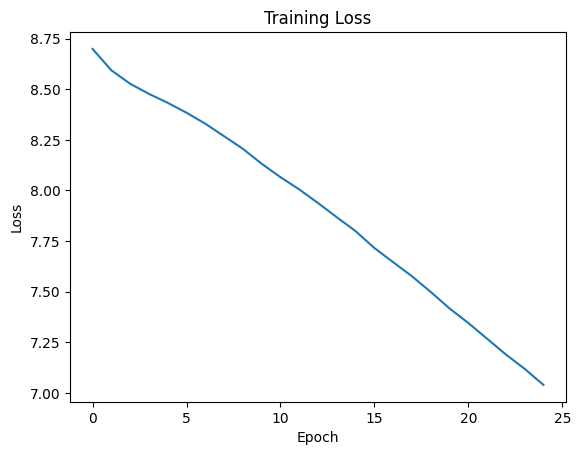

In [40]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_embedding = 512
n_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1
nums_epoch =25
loss_list = []

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_embedding, n_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(nums_epoch):
   #ToDo: complete the code
   transformer_out = transformer(src_data, tgt_data[:,:-1])
   # Compute loss
   loss = criterion(transformer_out.view(-1, tgt_vocab_size), tgt_data[:,1:].contiguous().view(-1))
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
   loss_list.append(loss.item())
   print(f'Epoch [{epoch+1}/{nums_epoch}], Loss: {loss.item():.4f} ')
   
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

